In [1]:
import pandas as pd
from pymongo import MongoClient, GEO2D
import pymongo
import json
import datetime
from bson.son import SON
import folium 
from math import *
import numpy as np
from IPython.display import display


In [2]:
import matplotlib.pyplot as plt

In [3]:
df_20150817 = pd.read_csv('/home/kathrin/Doctorado/bus_rio/Datos_Omnibus/morte_motoqueiro_20150817/20150817.txt', delimiter = ('\t'))

In [ ]:
df_20150817_line_316 = df_20150817[(df_20150817['line']=='316')]

In [5]:
df_20150817_line_317 = df_20150817[(df_20150817['line']=='317')]

In [11]:
#Estableciendo la conexion con la base de datos morte_motoquiro en MongoDB
db = MongoClient().morte_motoquiro_event

In [13]:
#la funcion $within recibe las coordenadas en orden inverso (primero longitud y después latitud)
list_initial_points_array = []
for row in db.dados20150817_line_317.find({}).sort("timestamp",pymongo.DESCENDING):
    list_initial_points_array.insert(len(list_initial_points_array), [row[u'timestamp'], row[u'latitude'], row[u'longitude'], row[u'speed']])
#convert the array in panda dataframe 
sort_initial_points = pd.DataFrame(list_initial_points_array, columns=['timestamp', 'latitude', 'longitude', 'speed'])


In [9]:
"""Funciones para renderizar el mapa en el html"""
from IPython.display import HTML
 
def inline_map(map):
    """
    Embeds the HTML source of the map directly into the IPython notebook.
    
    This method will not work if the map depends on any files (json data). Also this uses
    the HTML5 srcdoc attribute, which may not be supported in all browsers.
    """
    map._build_map()
    return HTML('<iframe srcdoc="{srcdoc}" style="width: 100%; height: 510px; border: none"></iframe>'.format(srcdoc=map.HTML.replace('"', '&quot;')))
 
def embed_map(map, path="map.html"):
    """
    Embeds a linked iframe to the map into the IPython notebook.
    
    Note: this method will not capture the source of the map into the notebook.
    This method should work for all maps (as long as they use relative urls).
    """
    map.create_map(path=path)
    return HTML('<iframe src="files/{path}" style="width: 100%; height: 510px; border: none"></iframe>'.format(path=path))

In [14]:
#Punto inicial del omnibus 316 Central do Brasil
initial_point = (-23.0224,-43.4823)
#Punto inicial del omnibus invertido
inverted_initial_point = (-43.4823, -23.0224)
#Punto final del omnibus 316 Centro
final_point = (-22.9049, -43.1917)
#Punto final del omnibus invertido
inverted_final_point = (-43.1917, -22.9049)


In [15]:
onibus316_shapes = pd.read_csv('/home/kathrin/Doctorado/bus_rio/Datos_Omnibus/Onibus/Shapes/gtfs_linha316-shapes.csv')
fmap316_0=folium.Map(location=[-22.923714, -43.258999], zoom_start=11)
locations316 = []
for row in onibus316_shapes.iterrows():
    #The 'latitude' and 'longitude' names correspond to column names in the original cceats dataframe
    locations316.insert(1, [ row[1]['latitude'], row[1]['longitude'] ])
    
#Pintando Circulos de radio de 50m alrededor de los puntos incial y final 
fmap316_0.simple_marker(final_point, popup='Centro')
fmap316_0.simple_marker(initial_point, popup='Barra')

#Punto inicial
fmap316_0.circle_marker(location=final_point, radius=50,line_color='green',
                 fill_color='#3186cc', fill_opacity=0.2)

#Punto inicial
fmap316_0.circle_marker(location=initial_point, radius=50,line_color='blue',
                 fill_color='#3186cc', fill_opacity=0.2)

fmap316_0.line(locations316)
embed_map(fmap316_0)

In [16]:
df_20150817_line_316_C41422 = df_20150817_line_316[(df_20150817_line_316['bus_id']=='C41422')]
#para seleccionar solo algunas columnas del dataframe, en este caso la columna 1(timestamp), la 4(latitude) y la 5(longitude)
important_columns = df_20150817_line_316_C41422.iloc[:,[0,3,4]]
myvector = important_columns.values.tolist()


In [17]:
#Funcion para calcular la distancia entre 2 puntos, teniendo en cuenta el radio de la tierra
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return (c * r)*1000 # return the distance in m

In [18]:
"""
funcion que dado un vector de lat, long y un punto A(lat,long), me devuelve un vector con
la distancia de cada par al punto A
 """
def vector_distancia(vector, point):
    vector_distance = []
    lat2 = point[0]
    long2 = point[1]
    for item in vector:
        lat1 = item[1]
        long1 = item[2]
        distance = haversine(long2, lat2, long1, lat1)
        latlon = (item[1], item[2])
        vector_distance.insert(len(vector_distance), [item[0],latlon, distance])
    df_vector_distance = pd.DataFrame(vector_distance, columns=['timestamp', 'latlon', 'distance'])
    return df_vector_distance   

In [19]:
dist_to_ini = vector_distancia(myvector, initial_point)
sorted_dist_to_ini = dist_to_ini.sort(["timestamp"])

dist_to_final = vector_distancia(myvector, final_point)
sorted_dist_to_final = dist_to_final.sort(["timestamp"])
sorted_dist_to_final

,timestamp,latlon,distance
0,17-08-2015 05:54:18,"(-22.904316, -43.19215)",79.633137
1,17-08-2015 05:54:53,"(-22.904316, -43.192158)",80.110213
2,17-08-2015 05:56:03,"(-22.904242, -43.191978)",78.511921
3,17-08-2015 05:57:13,"(-22.904234, -43.191998)",80.099599
4,17-08-2015 05:58:23,"(-22.904236, -43.191406)",79.738404
5,17-08-2015 05:58:58,"(-22.904127, -43.190872)",120.750978
6,17-08-2015 06:00:08,"(-22.903404, -43.188705)",348.970652
7,17-08-2015 06:01:18,"(-22.901686, -43.184101)",856.479939
8,17-08-2015 06:01:53,"(-22.900238, -43.181408)",1174.763584
9,17-08-2015 06:03:03,"(-22.900347, -43.179222)",1374.728253


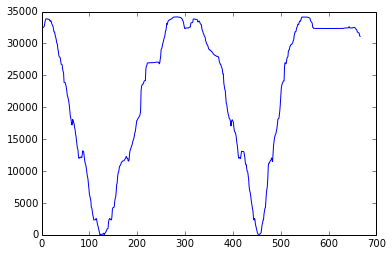

In [20]:
#ploteando el vector distancia entre cada uno de los puntos del recorrido y el punto inicial Barra
%matplotlib inline
plt.plot(sorted_dist_to_ini['distance'], color = 'b')
plt.show()

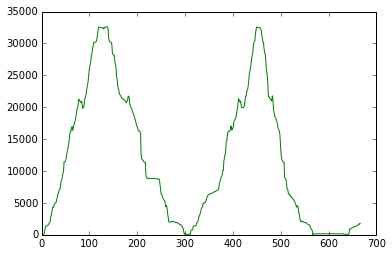

In [21]:
#ploteando el vector distancia entre cada uno de los puntos del recorrido y el punto final Central
%matplotlib inline
plt.plot(sorted_dist_to_final['distance'], color = 'g')

plt.show()

In [22]:
df_20150817_line_317_C41405 = df_20150817_line_317[(df_20150817_line_317['bus_id']=='C41405')]
 
#para seleccionar solo algunas columnas del dataframe, en este caso la columna 1, la 4 y la 5
important_columns_317_C41405 = df_20150817_line_317_C41405.iloc[:,[0,3,4]]
myvectornew = important_columns_317_C41405.values.tolist()

In [23]:
list_317_C41405_ok = df_20150817_line_317_C41405[(df_20150817_line_317_C41405['timestamp'] > '17-08-2015 10:48:05')& (df_20150817_line_317_C41405['timestamp'] < '17-08-2015 13:08:05')]

list_317_C41405_ok

,timestamp,bus_id,line,latitude,longitude,speed
1492280,17-08-2015 10:48:17,C41405,317,-22.904301,-43.189445,41.86
1493521,17-08-2015 10:48:52,C41405,317,-22.904623,-43.190186,1.11
1496557,17-08-2015 10:50:02,C41405,317,-22.905161,-43.192055,0.74
1499833,17-08-2015 10:51:12,C41405,317,-22.905624,-43.193359,14.08
1503561,17-08-2015 10:52:22,C41405,317,-22.905584,-43.196877,2.96
1505097,17-08-2015 10:52:57,C41405,317,-22.905588,-43.196854,0.37
1507732,17-08-2015 10:53:29,C41405,317,-22.905584,-43.196735,0.37
1523918,17-08-2015 10:58:56,C41405,317,-22.905600,-43.196781,0.00
1527317,17-08-2015 11:00:06,C41405,317,-22.905586,-43.196770,0.37
1531657,17-08-2015 11:01:16,C41405,317,-22.905611,-43.196770,0.19


In [24]:
dist_to_ini_317_C41405 = vector_distancia(myvectornew, initial_point)
sorted_dist_to_ini_317_C41405 = dist_to_ini_317_C41405.sort(["timestamp"])

dist_to_final_317_C41405 = vector_distancia(myvectornew, final_point)
sorted_dist_to_final_317_C41405 = dist_to_final_317_C41405.sort(["timestamp"])



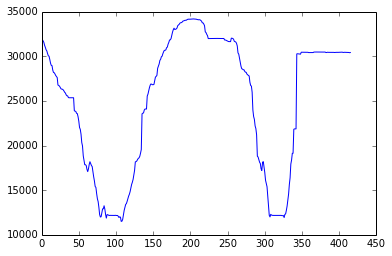

In [25]:
#distancia a barra
%matplotlib inline
plt.plot(sorted_dist_to_ini_317_C41405['distance'], color = 'b')
plt.show() 

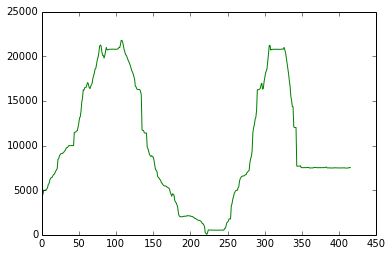

In [26]:
#ploteando el vector distancia entre cada uno de los puntos del recorrido y el punto final Central
%matplotlib inline
plt.plot(sorted_dist_to_final_317_C41405['distance'], color = 'g')

plt.show()

In [27]:
def days_hours_minutes(travel_time):
    hours = travel_time.seconds//3600 
    minutes = (travel_time.seconds//60)%60
    #print '%d hours, %d minutes' % (hours,minutes)
    if minutes < 10:
        minutes = str(0)+str(minutes)
    return str(hours) + ":"+ str(minutes)

In [28]:
#para saber el tipo de dato que almacena una columna         

g = sorted_dist_to_final_317_C41405.columns.to_series().groupby(sorted_dist_to_final_317_C41405.dtypes).groups
g

{dtype('float64'): ['distance'], dtype('O'): ['timestamp', 'latlon']}

In [29]:
#convirtiendo la columna timestamp en tipo datetime
set_of_times = sorted_dist_to_final_317_C41405['timestamp']
mytimestamp_list = []
for i in range(0, len(sorted_dist_to_final_317_C41405)-1):
    #ddist = set_of_points[i+1]-set_of_points[i]

    #time1 = datetime.datetime.strptime(set_of_times[i+1], "%d-%m-%Y %H:%M:%S")
    time0 = datetime.datetime.strptime(set_of_times[i], "%d-%m-%Y %H:%M:%S")
    #dtime = (time1-time0).total_seconds()/60
    #gradient = ddist/dtime
    mytimestamp_list.insert (len(mytimestamp_list), time0)
#convertir la lista "mytimestamp_list" a dataframe
df_mytimestamp_list = pd.DataFrame(mytimestamp_list, columns=['timestamp'])


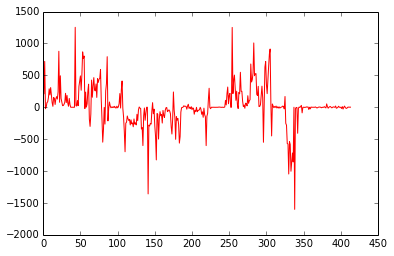

In [30]:

#calcular el gradiente(pendiente) = 0 para saber los conjuntos de maximos y minimos
set_of_points = sorted_dist_to_final_317_C41405['distance']
set_of_times = sorted_dist_to_final_317_C41405['timestamp']

gradient_list = []
gradient_matrix = [] #matriz que tiene 4 columnas tiempo1, tiempo2,distancia1, distancia2, pendiente 
#con los que se calcula la pendiente
for i in range(0, len(sorted_dist_to_final_317_C41405)-2):
    ddist = set_of_points[i+1]-set_of_points[i]

    time1 = datetime.datetime.strptime(set_of_times[i+1], "%d-%m-%Y %H:%M:%S")
    time0 = datetime.datetime.strptime(set_of_times[i], "%d-%m-%Y %H:%M:%S")
    dtime = (time1-time0).total_seconds()/60
    gradient = ddist/dtime
    gradient_list.insert (len(gradient_list), gradient)
    gradient_matrix.insert (len(gradient_matrix), [set_of_points[i], set_of_points[i+1],time0, time1, gradient ]) 
    df_gradient_matrix = pd.DataFrame(gradient_matrix, columns=['d1','d2','t1', 't2', 'pendiente'])

%matplotlib inline

plt.plot(gradient_list, color = 'r')

plt.show()    


In [31]:
df_gradient_matrix
stop_df_gradient_matrix = df_gradient_matrix[(df_gradient_matrix["pendiente"]==0)]
stop_df_gradient_matrix

,d1,d2,t1,t2,pendiente
37,9988.740912,9988.740912,2015-08-17 07:32:11,2015-08-17 07:32:46,0
38,9988.740912,9988.740912,2015-08-17 07:32:46,2015-08-17 07:33:56,0
39,9988.740912,9988.740912,2015-08-17 07:33:56,2015-08-17 07:35:06,0
40,9988.740912,9988.740912,2015-08-17 07:35:06,2015-08-17 07:36:16,0
41,9988.740912,9988.740912,2015-08-17 07:36:16,2015-08-17 07:39:11,0
42,9988.740912,9988.740912,2015-08-17 07:39:11,2015-08-17 07:42:06,0
139,11393.498409,11393.498409,2015-08-17 09:24:52,2015-08-17 09:26:02,0
140,11393.498409,11393.498409,2015-08-17 09:26:02,2015-08-17 09:27:12,0
252,1782.837968,1782.837968,2015-08-17 13:16:08,2015-08-17 13:17:18,0
253,1782.837968,1782.837968,2015-08-17 13:17:18,2015-08-17 13:17:53,0


In [32]:
df_mytimestamp_list
set_of_points = sorted_dist_to_final_317_C41405['distance']

In [33]:
#hacer una grafica interactiva con la libreria de python (plotly.plotly). Se instala por consola asi: sudo pip install plotly
#distancia del punto final (central)
import plotly.plotly as py
from plotly.graph_objs import *
import pandas as pd

#df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_orange_stock.csv')
#df.head()

trace = Scatter( x=df_mytimestamp_list['timestamp'], y = sorted_dist_to_final_317_C41405['distance'] )
data = Data([trace])

# IPython notebook
# py.iplot(data, filename='pandas-time-series')

py.iplot(data, filename='pandas-time-series')

In [38]:
df_20150817_line_316_C41422_range = df_20150817_line_316_C41422[(df_20150817_line_316_C41422['timestamp'] > '17-08-2015 13:00:18') & (df_20150817_line_316_C41422['timestamp'] < '17-08-2015 14:15:18')]
for row in df_20150817_line_316_C41422_range.iterrows():
    latlon = [ row[1]['latitude'], row[1]['longitude'] ]
    fmap316_0.polygon_marker( latlon, fill_color='red', num_sides=4, radius=6)
embed_map(fmap316_0)
#sentido central barra

In [35]:
import plotly.plotly as py
from plotly.graph_objs import *

trace0 = Scatter(
  x=[1, 2, 3, 4],
  y=[10, 15, 13, 17]
)
trace1 = Scatter(
  x=[1, 2, 3, 4],
  y=[16, 5, 11, 9]
)
data = Data([trace0, trace1])

py.iplot(data, filename = 'basic-line')

In [26]:
#esto es para graficar la porcion de la ruta que será analizada con las paradas representativas
for row in list_317_C41405_ok.iterrows():
    #The 'latitude' and 'longitude' names correspond to column names in the original cceats dataframe
    latlon = [ row[1]['latitude'], row[1]['longitude'] ]
    fmap316_0.polygon_marker( latlon, fill_color='orange', num_sides=4, radius=6)
    
    

embed_map(fmap316_0)